In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
def load_iris():
    iris = datasets.load_iris()
    X = iris.data[:, :2]  # Use first two features for visualization
    y = iris.target
    return X, y

In [3]:
def compute_lda_parameters(X, y):
    classes = np.unique(y)
    n_features = X.shape[1]
    overall_mean = np.mean(X, axis=0)
    
    # Compute within-class scatter matrix Sw and between-class scatter matrix Sb
    Sw = np.zeros((n_features, n_features))
    Sb = np.zeros((n_features, n_features))
    means = {}
    priors = {}
    
    for c in classes:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)
        means[c] = mean_c
        priors[c] = len(X_c) / len(X)
        
        Sw += np.cov(X_c, rowvar=False) * (len(X_c) - 1)
        diff_mean = (mean_c - overall_mean).reshape(n_features, 1)
        Sb += len(X_c) * (diff_mean @ diff_mean.T)
    
    # Compute projection matrix
    Sw_inv = np.linalg.inv(Sw)
    eigvals, eigvecs = np.linalg.eig(Sw_inv @ Sb)
    eigvecs = eigvecs[:, np.argsort(-eigvals)[:len(classes) - 1]]  # Select top eigenvectors
    
    return means, eigvecs, priors

In [4]:
def lda_decision_function(X, means, eigvecs, priors):
    X_proj = X @ eigvecs  # Project data onto new space
    means_proj = {c: means[c] @ eigvecs for c in means}
    
    n_samples = X_proj.shape[0]
    n_classes = len(means_proj)
    scores = np.zeros((n_samples, n_classes))
    
    for c in means_proj:
        mean_proj = means_proj[c]
        prior = priors[c]
        
        for i in range(n_samples):
            diff = X_proj[i] - mean_proj
            scores[i, c] = -0.5 * np.dot(diff, diff) + np.log(prior)
    
    return np.argmax(scores, axis=1)

In [5]:
def plot_decision_boundary(X, y, means, eigvecs, priors):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = lda_decision_function(grid_points, means, eigvecs, priors)
    predictions = predictions.reshape(xx.shape)
    
    plt.contourf(xx, yy, predictions, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('LDA Decision Boundary (Using Sw and Sb)')
    plt.show()

In [6]:
# Load data and train LDA
X, y = load_iris()
means, eigvecs, priors = compute_lda_parameters(X, y)
y_pred = lda_decision_function(X, means, eigvecs, priors)

# Compute accuracy
accuracy = np.mean(y_pred == y)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 80.67%


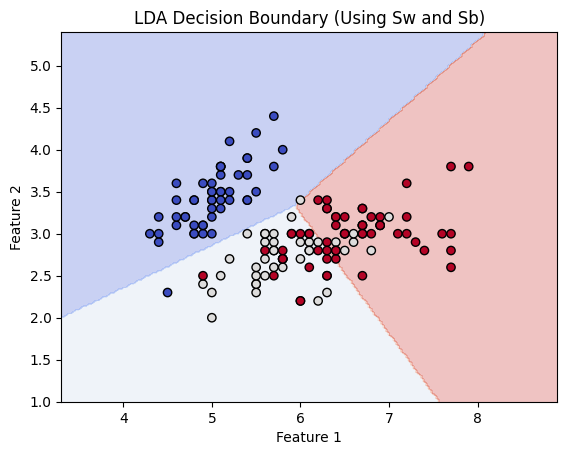

In [7]:
# Plot decision boundary
plot_decision_boundary(X, y, means, eigvecs, priors)
